```{eval-rst}
.. include:: sinebow.rst

```

{sinebow23}`Cell contours`
==================================

The boundary of a closed and bounded 2D region may be parameterized as a function of one variable. Instance masks, or more specifically, affinity graphs, allow us to traverse the boundary of a cell and index each pixel from 0 to N-1, where N is the number of boundary pixels. Indexed/parameterized boundaries are called contours.   


{header-2}`Example cells`
-------------------------
The [previous section](affinity.ipynb#affinity-segmentation) demonstrated the generation of cell contours in the context of self-contact, where a cyclic color map was applied to visualize the cell boundaries. Here we demonstrate how to convert contours to vector outlines with a simpler set of cell masks. We first preprocess the masks to remove any "spurs" (boundary pixels sharing only one face with a neighbor), then generate an affinity graph, compute the contours, and finally make a spline to interpolate a smooth outline through the contour pixels. 

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


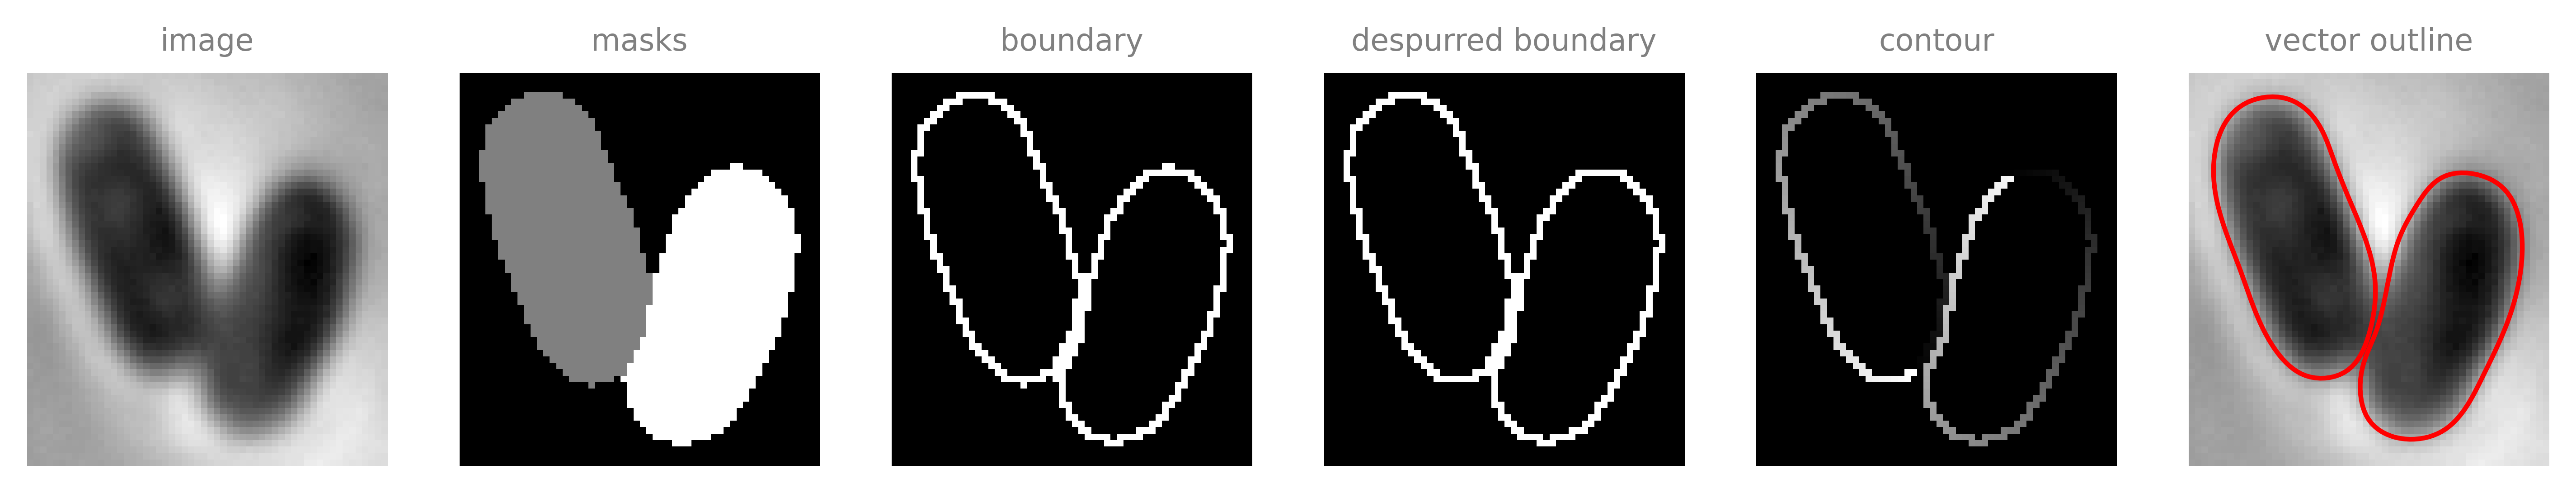

In [51]:
from scipy.interpolate import splprep, splev
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches


import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 600
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.frameon'] = False


import omnipose
import cellpose_omni
import numpy as np

from omnipose.plot import imshow

from pathlib import Path
import os, re
from cellpose_omni import io
import fastremap

omnidir = Path(omnipose.__file__).parent.parent
basedir = os.path.join(omnidir,'docs','_static')
# name = 'ecoli_phase'
name = 'ecoli'
ext = '.tif'
image = io.imread(os.path.join(basedir,name+ext))
masks = io.imread(os.path.join(basedir,name+'_labels'+ext))
slc = omnipose.measure.crop_bbox(masks>0,pad=0)[0]
masks = fastremap.renumber(masks[slc])[0]
image = image[slc]

# set up dimensions
msk = masks
dim = msk.ndim
shape = msk.shape
steps,inds,idx,fact,sign = omnipose.utils.kernel_setup(dim)

# remove spur points - this method is way easier than running core._despur() on the priginal affinity graph
bd = find_boundaries(msk,mode='inner',connectivity=2)
msk, bounds, _ = omnipose.core.boundary_to_masks(bd,binary_mask=msk>0,connectivity=1) 

# generate affinity graph
coords = np.nonzero(msk)
affinity_graph =  omnipose.core.masks_to_affinity(msk, coords, steps, inds, idx, fact, sign, dim)
neighbors = omnipose.utils.get_neighbors(tuple(coords),steps,dim,shape) # shape (d,3**d,npix)

# find contours 
contour_map, contour_list, unique_L = omnipose.core.get_contour(msk,
                                                                affinity_graph,
                                                                coords,
                                                                neighbors,
                                                                cardinal_only=1)

# make a figure
dpi=90
fig = imshow([image,masks,bd,bounds,contour_map,image],
             titles=['image','masks','boundary','despurred boundary','contour','vector outline'], 
             dpi=dpi)

# plot vector outlines on last panel 
ax = fig.get_axes()[-1]

# outline params
smooth_factor = 5 # smaller is smoother, higher follows pixel edges more tightly 
color = 'r' 


for contour in contour_list:
    if len(contour) > 1:
        pts = np.stack([c[contour] for c in coords]).T
        tck, u = splprep(pts.T, u=None, s=len(pts)/smooth_factor, per=1) 
        u_new = np.linspace(u.min(), u.max(), len(pts))
        x_new, y_new = splev(u_new, tck, der=0)

        # Define the points of the polygon
        points = np.column_stack([y_new, x_new])
        
        # Create a Path from the points
        path = mpath.Path(points, closed=True)
        
        # Create a PathPatch from the Path
        patch = mpatches.PathPatch(path, fill=None, edgecolor=color, linewidth= dpi/72, capstyle='round')
        
        ax.add_patch(patch)

fig

Currently, the contours are not following strict left- or right-handedness, and that is something I would like to improve. 
<!-- 
{header-2}`Curvature measurements`
--------------------------------- -->